# Imports

In [84]:
import os
import ast
import pandas as pd
import seaborn as sns
import logging
import pennylane as qml
import autograd.numpy as anp
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D


from datetime import date

from pennylane import numpy as np

from pennylane.optimize import SPSAOptimizer
from pennylane.optimize import AdamOptimizer
from pennylane.optimize import GradientDescentOptimizer
from pennylane.optimize import NesterovMomentumOptimizer

from sklearn import cluster
from sklearn import preprocessing

from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score
from sklearn.metrics.pairwise import euclidean_distances, pairwise_kernels, pairwise_distances
from sklearn.metrics.pairwise import rbf_kernel

from sklearn.model_selection import train_test_split

from sklearn.datasets import make_moons, make_blobs, make_circles

plt.style.use('dark_background')

seed = 42

np.random.seed(seed)

# Circuit

In [74]:
def default_embedding(x, wires):
    for i in wires:
        if i % 2 == 0:
            qml.RY(x[0], wires=i)
        else:
            qml.RX(x[1], wires=i)

# Ampliture Embedding
def amplitude_embedding(x, wires):
    qml.AmplitudeEmbedding(features=x, pad_with=2, wires=wires, normalize=True)

# Minimally Expressive Embedding (4 qubits, replicação de dados)
def minimally_expressive_embedding(x, wires):
    # Replicar dados: x[0] em qubits 0 e 2; x[1] em qubits 1 e 3
    for i in wires:
        if i % 2 == 0:
            qml.RX(x[0] * 2 * np.pi, wires=wires[i])
            qml.RY(np.pi / 4, wires=wires[i])
            qml.RZ(np.pi / 4, wires=wires[i])   
        else:
            qml.RX(x[1] * 2 * np.pi, wires=wires[i])
            qml.RY(np.pi / 4, wires=wires[i])
            qml.RZ(np.pi / 4, wires=wires[i])

def entanglement(W, n_qubits, n_entanglement):
    for camada in range(len(W)):
        # Aplica rotações em cada qubit para a camada atual
        for qubit in range(n_qubits):
            params = W[camada][qubit]
            qml.Rot(params[0], params[1], params[2], wires=qubit)
        
        # Aplica o entrelaçamento baseado em n_entanglement
        for ent in range(n_entanglement):
            # Alterna o padrão de entrelaçamento com base na camada, ent e qubit
            for q in range(n_qubits - 1):
                if (camada + ent + q) % 2 == 0:
                    controle = q
                    alvo = (q + 1) % n_qubits
                else:
                    controle = (q + 1) % n_qubits
                    alvo = q
                qml.CNOT(wires=[controle, alvo])


def circuit(weights, X, n_quibits, n_entanglement, embedding_type = 'AE'):
    if embedding_type == 'AE':
        default_embedding(X, wires=range(n_quibits))
    elif embedding_type == 'MEE':
        minimally_expressive_embedding(X, wires=range(n_quibits))
    elif embedding_type == 'AmpE':
        amplitude_embedding(X, wires=range(n_quibits))

    entanglement(weights, n_quibits, n_entanglement)

    return qml.expval(qml.PauliZ(wires=0))

def create_device(n_quibits):
    return qml.device("lightning.gpu", wires=n_quibits)

def create_qnode(n_quibits, n_entanglement, embedding_type):
    dev = create_device(n_quibits)

    @qml.qnode(dev, interface="autograd", diff_method="parameter-shift")
    def qnode(weights, X):
        return circuit(weights, X, n_quibits, n_entanglement, embedding_type)

    return qnode

def qvc_classifier(qnode, w, b, X):
    return qnode(w, X) + b

# Quantum Kernel

In [41]:
##### TESTE UTILIZANDO O DEFAULT DO PENNYLANE #########

def layer(x, params, wires, i0=0, inc=1):
    """Building block of the embedding ansatz"""
    i = i0
    for j, wire in enumerate(wires):
        qml.Hadamard(wires=[wire])
        qml.RZ(x[i % len(x)], wires=[wire])
        i += inc
        qml.RY(params[0, j], wires=[wire])

    n_wires = len(wires)
    for p, w in zip(params[1], wires):
        qml.CRZ(p, wires=[w % n_wires, (w + 1) % n_wires])

def ansatz(x, params, wires):
    """The embedding ansatz"""
    for j, layer_params in enumerate(params):
        layer(x, layer_params, wires, i0=j * len(wires))

adjoint_ansatz = qml.adjoint(ansatz)

def kernel(x1, x2, params, n_qubits):
    dev = qml.device("default.qubit", wires=n_qubits)

    @qml.qnode(dev)
    def kernel_circuit(x1, x2, params):
        ansatz(x1, params, wires=range(n_qubits))
        adjoint_ansatz(x2, params, wires=range(n_qubits))
        return qml.probs(wires=range(n_qubits))

    return kernel_circuit(x1, x2, params)[0]


In [ ]:
def quantum_rbf_kernel(X1, X2, gamma, wires):
    """
    Kernel quântico similar ao RBF.
    
    Args:
        X1, X2: Dados de entrada (vetores)
        gamma: Parâmetro de largura do kernel (equivalente ao RBF clássico)
        wires: Número de qubits (deve ser igual à dimensão dos dados)
    """
    dev = qml.device("default.qubit", wires=wires)
    
    @qml.qnode(dev)
    def circuit(x1, x2):
        # Codificação dos dados nos ângulos de rotação
        for i in range(wires):
            qml.RY(gamma * (x1[i] - x2[i])**2, wires=i)
        
        # Camada de entrelaçamento para criar interferência
        for i in range(wires - 1):
            qml.CNOT(wires=[i, i+1])
        
        # Medida da sobreposição entre estados
        return qml.probs(wires=range(wires))
    
    # Calcula a similaridade como a probabilidade do estado |00⟩
    prob_00 = circuit(X1, X2)[0]
    return prob_00


# Cluster Assingment

In [174]:
def cluster_assingment(outputs):
    cluster_probs = 1 / (1 + np.exp(-outputs))
    print(cluster_probs)
    return (cluster_probs > 0.5).astype(int)

# Show clusters

In [172]:
def print_decision_region(
        X, 
        qnode, 
        x_max, 
        y_max, 
        weights, 
        bias
    ):
    cm = 'viridis'

    # Create subplots
    fig = plt.figure(figsize=(14, 6))
    ax1 = fig.add_subplot(121, projection='3d')
    ax2 = fig.add_subplot(122)

    # # Generate grid for decision boundaries
    xx, yy = np.meshgrid(np.linspace(0.0, x_max, 50), np.linspace(0.0, y_max, 50))
    X_grid = np.array([[x, y] for x, y in zip(xx.flatten(), yy.flatten())])

    # # Compute predictions and thresholds for grid points
    predictions_grid = np.array([qvc_classifier(qnode, weights, bias, xi) for xi in X_grid])
    
    # # Reshape for plotting
    Z_pred = predictions_grid.reshape(xx.shape)

    # ================= 3D Plot =================
    # Plot data points
    data_predictions = np.array([qvc_classifier(qnode, weights, bias, xi) for xi in X])
    # data_thresholds = compute_threshold(X, theta)
    # cluster_labels = (data_predictions > data_thresholds).astype(int)

    sc = ax1.scatter(X[:,0], X[:,1], data_predictions, 
                    c=cluster_assingment(data_predictions), cmap=cm, s=50, edgecolors='k', vmin=-1, vmax=1)
    
    ax1.set_title(f"3D Quantum Embedding")
    ax1.set_xlabel("Feature 1")
    ax1.set_ylabel("Feature 2")
    ax1.set_zlabel("Circuit Output")
    ax1.view_init(elev=15, azim=45)
    
    # ================= 2D Plot =================
    # Melhorias no gráfico 2D
    ax2.set_title(f"Mapa de Calor e Fronteira de Decisão", pad=20)

    # 1. Mapa de temperatura melhorado
    heatmap = ax2.contourf(xx, yy, Z_pred, levels=50, cmap='viridis', alpha=0.8)
    fig.colorbar(heatmap, ax=ax2, label='Saída do Circuito', shrink=0.8)

    # 4. Pontos com bordas contrastantes e transparência
    scatter = ax2.scatter(X[:,0], X[:,1], c=cluster_assingment(data_predictions), cmap='coolwarm',
                        s=60, edgecolors='black', linewidth=0.8, alpha=0.9)

    # 6. Elementos adicionais
    ax2.grid(True, linestyle=':', alpha=0.3)
    ax2.set_aspect('equal', 'box')

    # Calculate and display metrics
    if len(np.unique(cluster_assingment(data_predictions))) > 1:
        silhouette = silhouette_score(X, cluster_assingment(data_predictions))
        davies = davies_bouldin_score(X, cluster_assingment(data_predictions))
        calinski = calinski_harabasz_score(X, cluster_assingment(data_predictions))

        metric_text = (
            f"Silhouette: {silhouette:.2f}\n"
            f"Davies-Bouldin: {davies:.2f}\n"
            f"Calinski-Harabasz: {calinski:.2f}"
        )
        
        fig.text(0.95, 0.95, metric_text,
                 transform=fig.gca().transAxes,
                 ha='right', va='top')
    else:
        fig.text(0.95, 0.95, "Metrics require\nmultiple clusters",
                 transform=plt.gca().transAxes,
                 ha='right', va='top')


    plt.tight_layout()
    plt.show()
    # # Save the plot
    # file_path = os.path.join(folder, graph_name)
    # plt.savefig(file_path)
    # plt.close()

# Cost

In [ ]:
def cost_function(
    weights,       # Parâmetros do circuito quântico
    bias,          # Viés do circuito
    K,
    qnode,         # Circuito quântico (QNode)
    X,             # Dados originais (n x d)
    n_clusters,    # Número de Qubits
    epsilon=1e-8
):
    outputs = np.array(
        [qvc_classifier(qnode=qnode, w=weights, b=bias, X=x) for x in X]
    )

    # Passo 2: Atribuição suave de clusters usando sigmoid
    cluster_probs = 1 / (1 + np.exp(-outputs))  # Probabilidades para cluster 0
    cluster_weights = [cluster_probs, 1 - cluster_probs]  # Pesos para ambos clusters
    
    total_cost = 0.0
    
    # Passo 3: Cálculo suave para cada cluster
    for j in range(n_clusters):
        # Pesos suaves para o cluster j
        w_j = cluster_weights[j][:, np.newaxis]  # Transforma em vetor coluna

        # Termo do traço suave
        weighted_K = w_j * K * w_j.T  # (n x n)

        trace_term = np.sum(weighted_K)
        
        # Termo de normalização suave
        sum_term = np.sum(weighted_K)
        normalization = sum_term / (np.sum(w_j) + epsilon)
        
        # Custo para o cluster j
        cluster_cost = trace_term - normalization
        reg_term = 0.01 * np.sum(w_j**2)  # Regularização L2

        total_cost += cluster_cost
        total_cost += reg_term
        
    return total_cost

# Train Function

In [169]:
def train(
    qnode, 
    features,
    n_params,
    n_qubits,
    n_layers,
    n_clusters,
    weight_init_max, 
    optimizer,
    dic_optimizer,
    cost,
    seed,
    iterations=100, 
    batch_size=32
):
    # Split data into 70% training and 30% validation
    X_train, X_val = train_test_split(features, test_size=0.3, shuffle=True, random_state=seed)

    all_costs = []  # To store cost values
    all_iterations = []

    # Initialize optimizer
    opt = optimizer(**dic_optimizer)
    
    # Initialize weights and bias with uniform distribution
    weights_init = np.random.uniform(
        -weight_init_max, weight_init_max, 
        (n_layers, n_qubits, n_params), 
        requires_grad=True
    )
    bias_init = np.array(0.0, requires_grad=True)

    weights = weights_init
    bias = bias_init

    # Desenho do circuito
    # qml.draw_mpl(qnode)(weights, features[0])

    training_info = {
        "best_weights": weights,
        "best_bias": bias,
        "best_cost": float('inf'),
        "silhouette": None,
        "davies_bouldin": None,
        "calinski_harabasz": None
    }

    patience = 20
    no_improvement = 0

    # K = np.zeros((len(features), len(features)))

    # for i in range(len(features)):
    #     for j in range(len(features)):
    #         K[i, j] = quantum_rbf_kernel(features[i], features[j], 0.5, 2)

    K = rbf_kernel(features, gamma=0.5)
    sns.heatmap(K, annot=False, cmap="viridis")

    # Training loop
    for it in range(iterations):
        # opt.reset()

        # Mini-batch sampling (ensure batch_size doesn't exceed training data size)
        current_batch_size = min(batch_size, len(X_train))
        # print(current_batch_size)
        batch_index = np.random.choice(len(X_train), current_batch_size, replace=False)
        X_train_batch = X_train[batch_index]

        K_batch = K[batch_index][:, batch_index]

        wrapped_cost_function = lambda weights, bias: cost(weights, bias, K_batch, qnode, X_train_batch, n_clusters)

        # Train model on batch
        params = [weights, bias]
        (weights, bias), iteration_cost = opt.step_and_cost(wrapped_cost_function, *params)
        # print(weights)
        
        # Update best weights and bias if cost improves
        if iteration_cost < training_info['best_cost']:
            training_info['best_weights'] = weights
            training_info['best_bias'] = bias
            training_info['best_cost'] = iteration_cost
            no_improvement = 0
        else:
            no_improvement += 1

        all_costs.append(iteration_cost)
        all_iterations.append(it + 1)        

        print(f"Iter: {it + 1:5d} | Cost: {iteration_cost:0.7f} | Best Cost: {training_info['best_cost']:0.7f}")

        # Early stopping if no improvement
        if no_improvement >= patience:
            break

    # Validation metrics
    predictions_val = np.array([qvc_classifier(qnode, training_info['best_weights'], training_info['best_bias'], xi) for xi in X_val])
    predictions_val = cluster_assingment(predictions_val)
   
    if len(np.unique(predictions_val)) > 1:
        training_info['davies_bouldin'] = davies_bouldin_score(X_val, predictions_val)
        training_info['calinski_harabasz'] = calinski_harabasz_score(X_val, predictions_val)
        training_info['silhouette'] = silhouette_score(X_val, predictions_val)

    return (all_costs,
            training_info["best_cost"], 
            training_info["best_weights"], 
            training_info["best_bias"], 
            # training_info['best_theta'], 
            training_info["silhouette"], 
            training_info["davies_bouldin"], 
            training_info["calinski_harabasz"])

# Normalize data

In [79]:
def normalize_data_transformY(X, y, range_init, range_end, plot=True):
  X_scaled = preprocessing.normalize(X,axis=0)

  scaler = preprocessing.MinMaxScaler(feature_range=(range_init, range_end))
  X_scaled = scaler.fit_transform(X)

  X = X_scaled

  if y is not None:
    y = 2*y - 1

  if plot:
    plt.figure(figsize=(4, 4))
    plt.title("Base de dados", fontsize="small")
    plt.scatter(X[:, 0], X[:, 1], marker="o", s=25, c=y if y is not None else None, edgecolor="k")
    plt.show()

  return X_scaled, y

# Execution Function

# 2 Moons

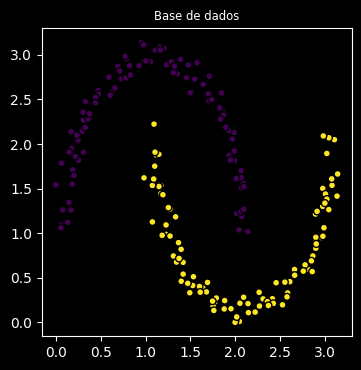

In [142]:
X, y = make_moons(n_samples=200, noise=0.05, random_state=seed)

X, y = normalize_data_transformY(X, y, range_init=0, range_end=np.pi)

## Execution

Iter:     1 | Cost: 866.8501491 | Best Cost: 866.8501491
Iter:     2 | Cost: 1561.9213373 | Best Cost: 866.8501491
Iter:     3 | Cost: 1634.2322039 | Best Cost: 866.8501491
Iter:     4 | Cost: 1587.8774042 | Best Cost: 866.8501491
Iter:     5 | Cost: 1568.6527297 | Best Cost: 866.8501491
Iter:     6 | Cost: 1490.9829370 | Best Cost: 866.8501491
Iter:     7 | Cost: 1363.3453363 | Best Cost: 866.8501491
Iter:     8 | Cost: 1432.3920982 | Best Cost: 866.8501491
Iter:     9 | Cost: 1288.7400020 | Best Cost: 866.8501491
Iter:    10 | Cost: 834.0709599 | Best Cost: 834.0709599
Iter:    11 | Cost: 1098.7087264 | Best Cost: 834.0709599
Iter:    12 | Cost: 1502.2478315 | Best Cost: 834.0709599
Iter:    13 | Cost: 1526.7463969 | Best Cost: 834.0709599
Iter:    14 | Cost: 1430.8116988 | Best Cost: 834.0709599
Iter:    15 | Cost: 1518.4526288 | Best Cost: 834.0709599
Iter:    16 | Cost: 1573.2372141 | Best Cost: 834.0709599
Iter:    17 | Cost: 1476.1591307 | Best Cost: 834.0709599
Iter:    18 | Co

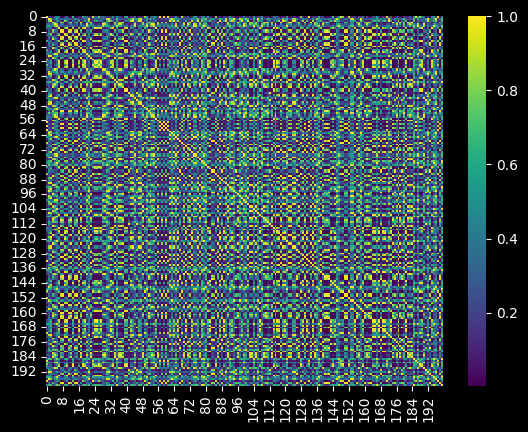

In [170]:
n_qubits = 2
n_params = 3
n_layers = 1
n_entanglement = 1
embedding_type = 'AE'
qnode = create_qnode(n_qubits, n_entanglement=n_entanglement, embedding_type=embedding_type)

# intra_loss_history = []
# inter_loss_history = []
# cluster_penality_history = []
# total_loss_history = []

all_costs, cost, weights, bias, score_silhouette, score_davies, score_calinski = train(
    qnode=qnode,
    features=X,
    n_params=n_params,
    n_qubits=n_qubits,
    n_layers=n_layers,
    n_clusters=2,
    weight_init_max=np.pi,
    optimizer=SPSAOptimizer,
    # optimizer=AdamOptimizer,
    # dic_optimizer={"stepsize": 0.1},
    dic_optimizer={"maxiter": 100},
    # n_entanglement=n_entanglement,
    # embedding_type=embedding_type,
    cost=cost_function,
    seed=seed,
    iterations=100,
    batch_size=64
)

# plot_loss_evolution(intra_loss_history, inter_loss_history, cluster_penality_history, total_loss_history)

[0.9401186  0.78713147 0.82623905 0.74558566 0.8620743  0.87796446
 0.93118511 0.71226227 0.70223951 0.88180083 0.9249113  0.70031659
 0.71800482 0.93642927 0.70020077 0.70141682 0.90551598 0.76605962
 0.93888206 0.92587128 0.86457825 0.78995776 0.77960924 0.93887359
 0.92341333 0.91981805 0.93741644 0.92661225 0.87028077 0.85333641
 0.77392955 0.78769223 0.89786155 0.93615921 0.77872396 0.89393766
 0.83522731 0.82985095 0.71856758 0.9360993  0.93555837 0.70096179
 0.85757158 0.80485433 0.86784877 0.70007706 0.82191813 0.79630427
 0.80214117 0.93728926 0.8797485  0.70596532 0.78386127 0.86203045
 0.88206742 0.93551164 0.81768616 0.9403653  0.70409758 0.93945538
 0.70552587 0.93887931 0.83458773 0.77696566 0.85122649 0.88229113
 0.87410266 0.70016568 0.93858647 0.82821773 0.90385124 0.86441553
 0.72962853 0.8691632  0.88644959 0.89612985 0.80772114 0.81981967
 0.89455243 0.88769304 0.77601269 0.93459967 0.89343813 0.7002056
 0.70052297 0.93802282 0.73391742 0.84660683 0.70007247 0.91674

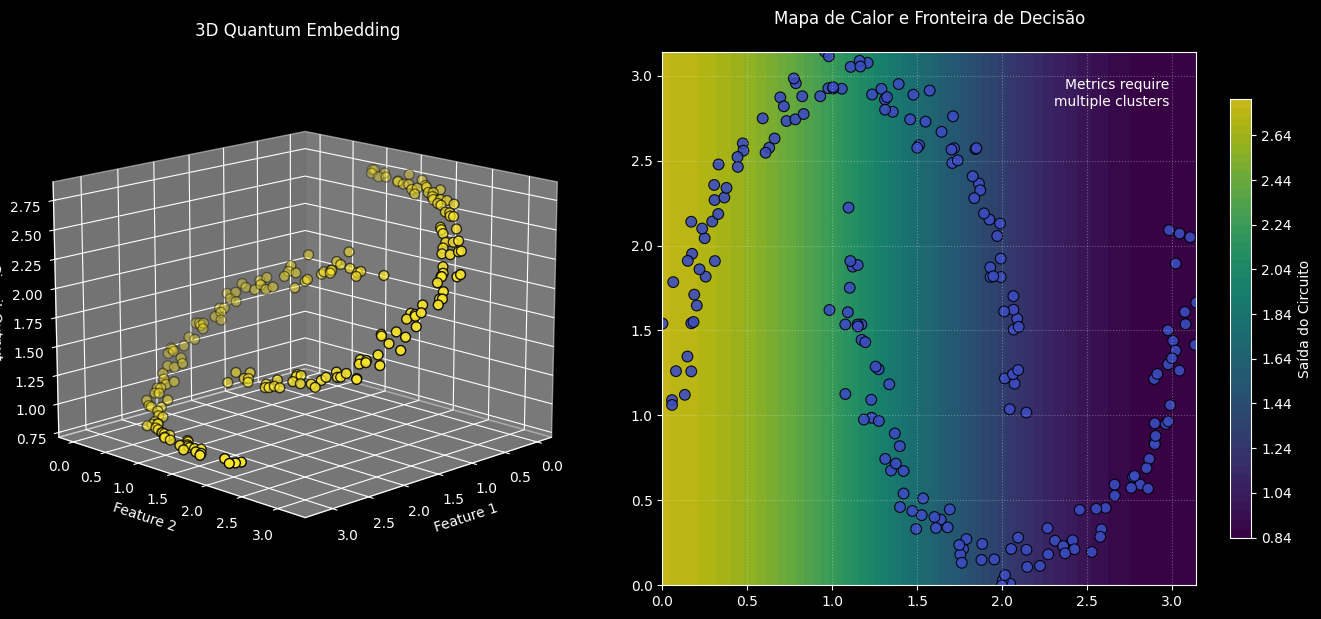

In [176]:
print_decision_region(X, qnode, np.pi, np.pi, weights, bias)

In [164]:
n_qubits = [2, 4]
n_layers = [2, 4]
n_params = 3
circuits = {
    "type1": 1,
    "type2": 3,
    "type3": 5
}

optimizers = [
    SPSAOptimizer,
    NesterovMomentumOptimizer,
    AdamOptimizer,
    GradientDescentOptimizer
]

optimizer_params = {
    'NesterovMomentumOptimizer': {'stepsize': 0.01, 'momentum': 0.9},
    'GradientDescentOptimizer': {'stepsize': 0.01},
    'SPSAOptimizer': {'maxiter': 100, 'alpha': 0.602, 'c': 0.101, 'gamma': 0.101},
    'AdamOptimizer': {'stepsize': 0.01}
}

embedding_types = [
    "AE",
    "AmpE",
    "MEE"
]

batchs_size = [
    32,
    64
]

log_results = []

for batch_size in batchs_size:
    for qubits in n_qubits:
        for layers in n_layers:
            for optimizer in optimizers:
                for circuit_type in circuits.keys():
                    for embedding in embedding_types:
                        qnode = create_qnode(qubits, n_entanglement=circuits[circuit_type], embedding_type=embedding)

                        all_costs, cost, weights, bias, thresholds, score_silhouette, score_davies, score_calinski = train(
                            qnode=qnode,
                            features=X,
                            n_params=n_params,
                            n_qubits=qubits,
                            n_layers=layers,
                            weight_init_max=np.pi,
                            optimizer=optimizer,
                            dic_optimizer=optimizer_params[optimizer.__name__],
                            n_entanglement=circuits[circuit_type],
                            embedding_type=embedding,
                            cost=cost_function,
                            seed=seed,
                            iterations=100,
                            batch_size=batch_size
                        )

                        # Adicionar os resultados ao log
                        log_results.append({
                            'n_entanglement': circuits[circuit_type],
                            'optimizer': optimizer.__name__,
                            'n_qubits': qubits,
                            'n_layers': layers,
                            'score_davies': score_davies,
                            'score_calinski': score_calinski,
                            'score_silhouette': score_silhouette,
                            'cost': cost,
                            'weights': weights.tolist(),  # Convertendo para lista, caso seja um array
                            'bias': bias, # Convertendo para lista, caso seja um array
                            'qnode': qnode,
                            'all_costs': all_costs,
                            'embedding_type': embedding,
                            'batch_size': batch_size,
                            'thresholds': thresholds
                        })

# Salvar o log em um arquivo CSV
log_df = pd.DataFrame(log_results)
log_df.to_csv(f'moon_testes.csv', index=False)

TypeError: train() got an unexpected keyword argument 'n_entanglement'

# Blobs

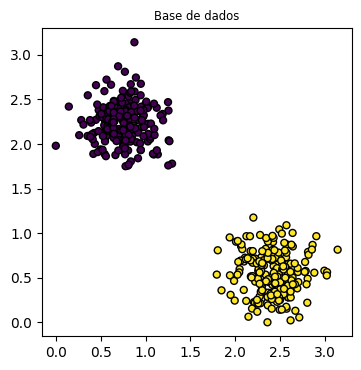

In [ ]:
X, y = make_blobs(n_samples=400, centers=2, random_state=seed)

X, y = normalize_data_transformY(X,y, range_init=0, range_end=np.pi)

## Execution

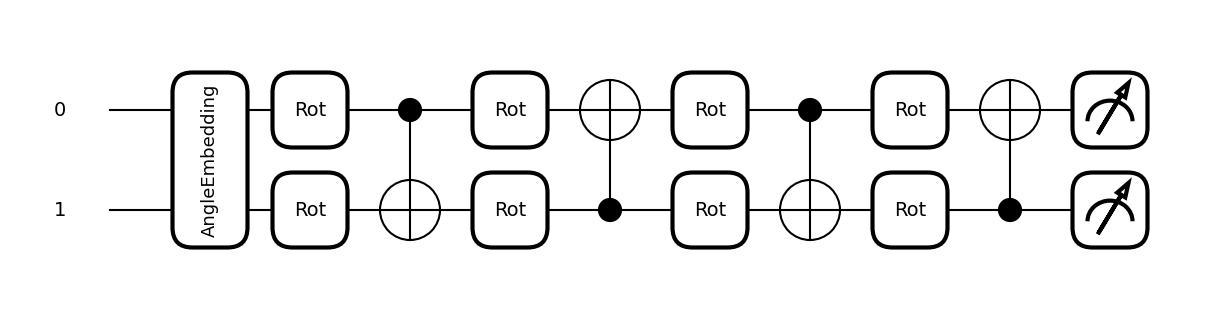

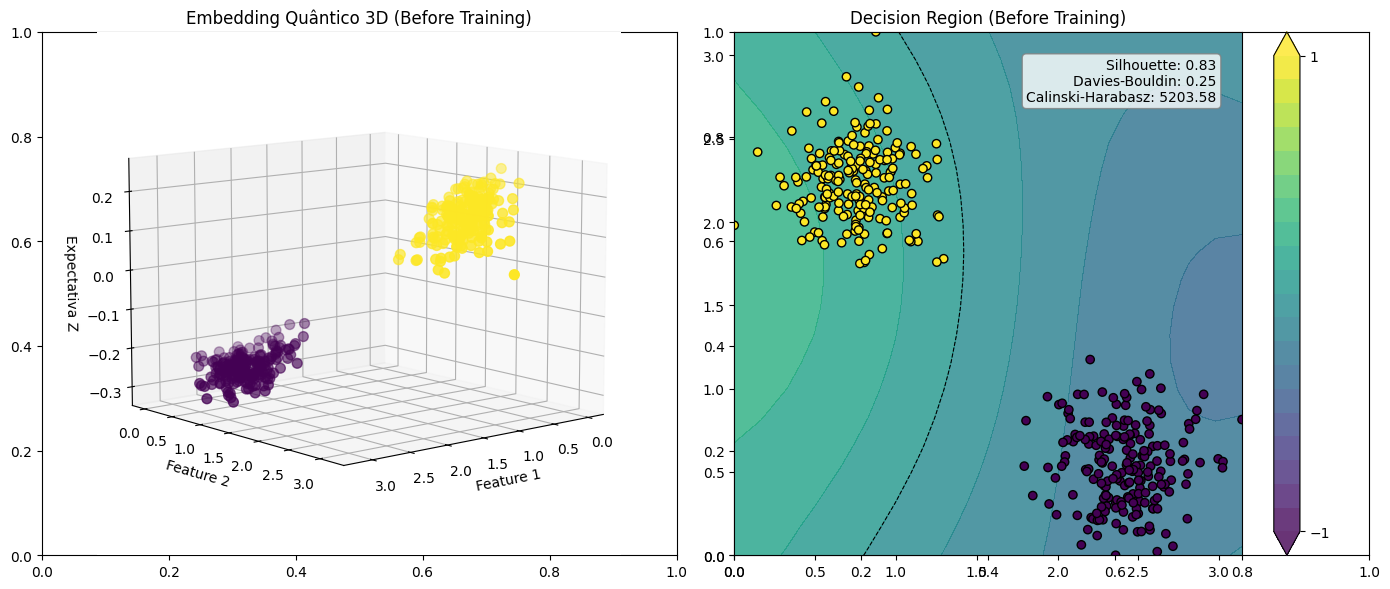

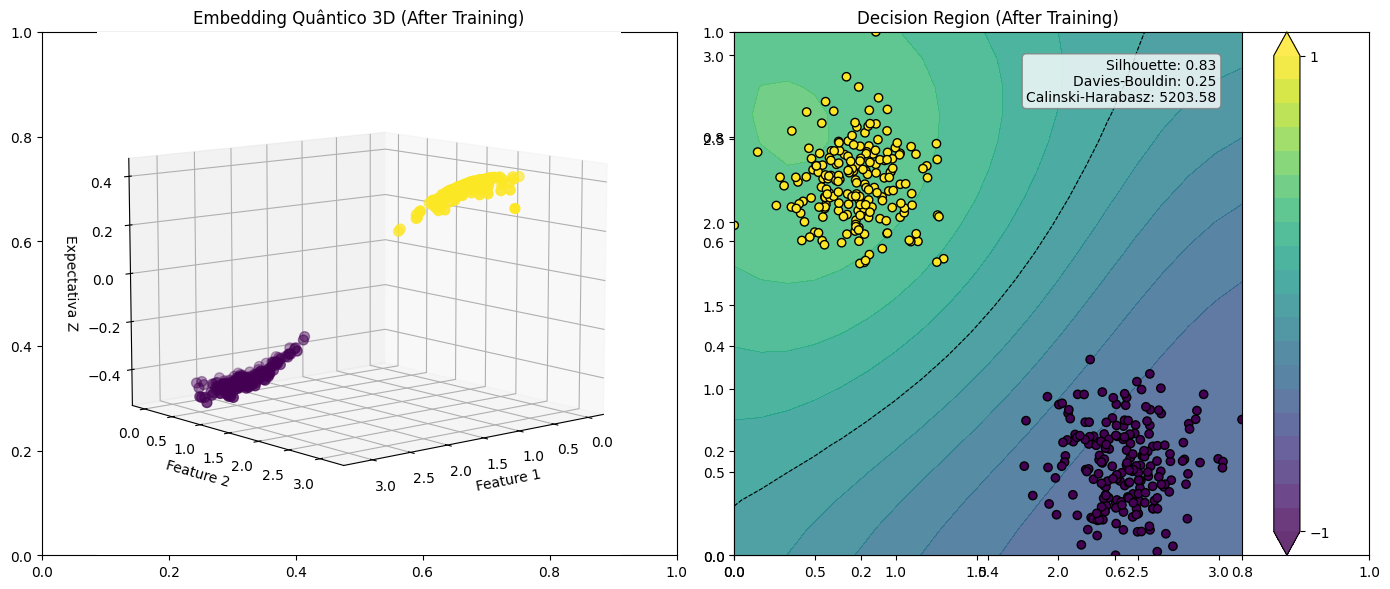

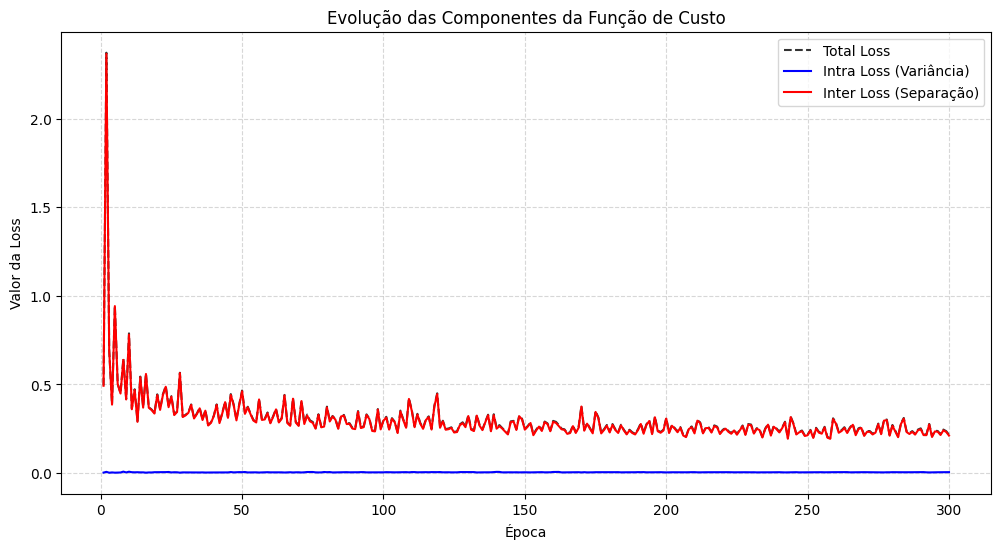

In [ ]:
n_qubits = 2
n_params = 3
n_layers = 4
qnode = create_qnode(n_qubits, 1, embedding_type='AE')

intra_loss_history = []
inter_loss_history = []
total_loss_history = []

cost, weights, bias, score_silhouette, score_davies, score_calinski = train(
    qnode=qnode,
    features=X,
    n_params=n_params,
    n_qubits=n_qubits,
    n_layers=n_layers,
    weight_init_max=np.pi,
    optimizer=SPSAOptimizer,
    dic_optimizer={"maxiter": 1000},
    seed=seed,
    iterations=100,
    batch_size=32
)

plot_loss_evolution(intra_loss_history, inter_loss_history, total_loss_history)

# Circles

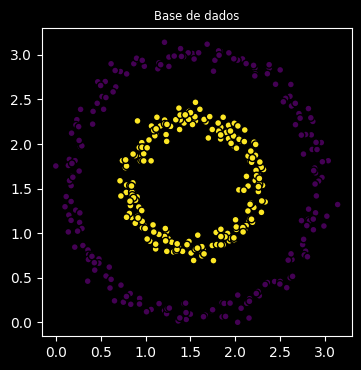

In [68]:
X, y = make_circles(
    (200, 200), factor=0.5, noise=0.05, random_state=seed
)

X, y = normalize_data_transformY(X, y, range_init=0, range_end=np.pi)

## Execution

0.19870115198751231
0.3379047666253652
0.2860708337260173
0.23257895058991992
0.23398921930906164
0.2911325620339279
Iter:     1 | Cost: 711.7881880 | Best Cost: 711.7881880


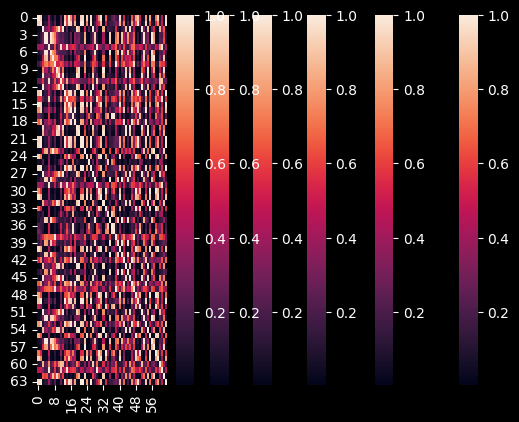

In [88]:
n_qubits = 2
n_params = 3
n_layers = 2
n_entanglement = 5
embedding_type = 'AE'
qnode = create_qnode(n_qubits, n_entanglement=n_entanglement, embedding_type=embedding_type)

# intra_loss_history = []
# inter_loss_history = []
# cluster_penality_history = []
# total_loss_history = []

all_costs, cost, weights, bias, score_silhouette, score_davies, score_calinski = train(
    qnode=qnode,
    features=X,
    n_params=n_params,
    n_qubits=n_qubits,
    n_layers=n_layers,
    n_clusters=2,
    weight_init_max=np.pi,
    # optimizer=SPSAOptimizer,
    optimizer=SPSAOptimizer,
    # dic_optimizer={"stepsize": 0.01},
    dic_optimizer={"maxiter": 1000},
    # n_entanglement=n_entanglement,
    # embedding_type=embedding_type,
    cost=cost_function,
    seed=seed,
    iterations=1,
    batch_size=64
)

# plot_loss_evolution(intra_loss_history, inter_loss_history, cluster_penality_history, total_loss_history)

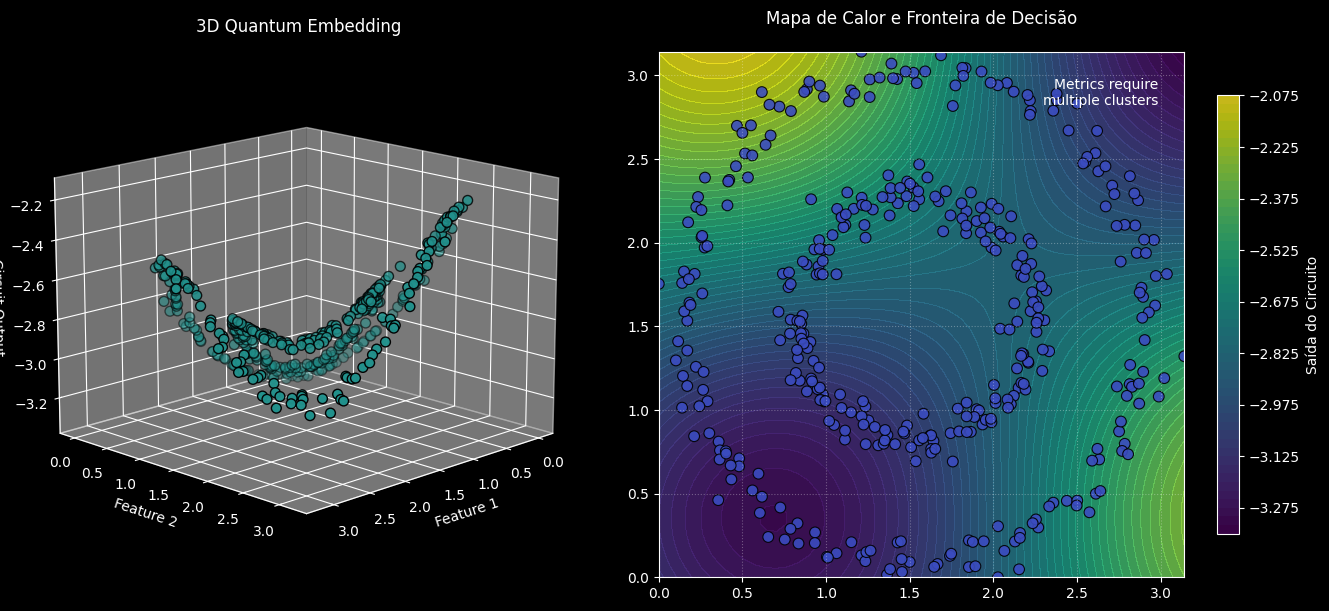

In [ ]:
print_decision_region(X, qnode, np.pi, np.pi, weights, bias)